# Imports

## For plots

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm #for better display of FITS images

%matplotlib notebook

plt.rc('figure', figsize=(9,3))
plt.rcParams["image.cmap"] = "inferno"

## Imports from standard packages

In [2]:
import numpy as np
from scipy.interpolate import interp1d
from astropy.io import fits
from astropy.convolution import convolve, Box1DKernel

## Local imports

In [3]:
from overlap import TrpzOverlap
from utils import grid_from_map, get_soss_grid, oversample_grid

# Read ref files

In [4]:
# Read relevant files
wv_1 = fits.open("Ref_files/wavelengths_m1.fits")[0].data
wv_2 = fits.open("Ref_files/wavelengths_m2.fits")[0].data
T1 = fits.open("Ref_files/trace_profile_m1.fits")[0].data.squeeze()
T2 = fits.open("Ref_files/trace_profile_m2.fits")[0].data.squeeze()

# Convert to float (fits precision is 1e-8)
wv_1 = wv_1.astype(float)
wv_2 = wv_2.astype(float)
T1 = T1.astype(float)
T2 = T2.astype(float)

In [5]:
# Normalised spatial profile
P1 = T1 / T1.sum(axis=0)
P1[np.isnan(P1)] = 0.

P2 = T2 / T2.sum(axis=0)
P2[np.isnan(P2)] = 0.

/Users/antoinedb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/Users/antoinedb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


<IPython.core.display.Javascript object>


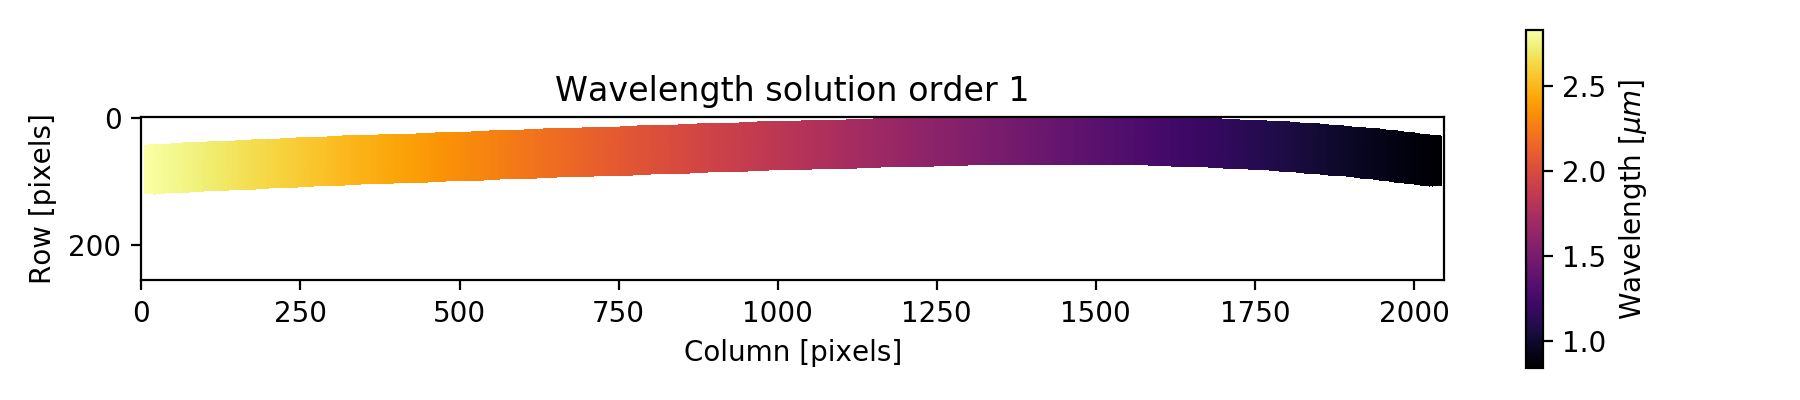

<IPython.core.display.Javascript object>


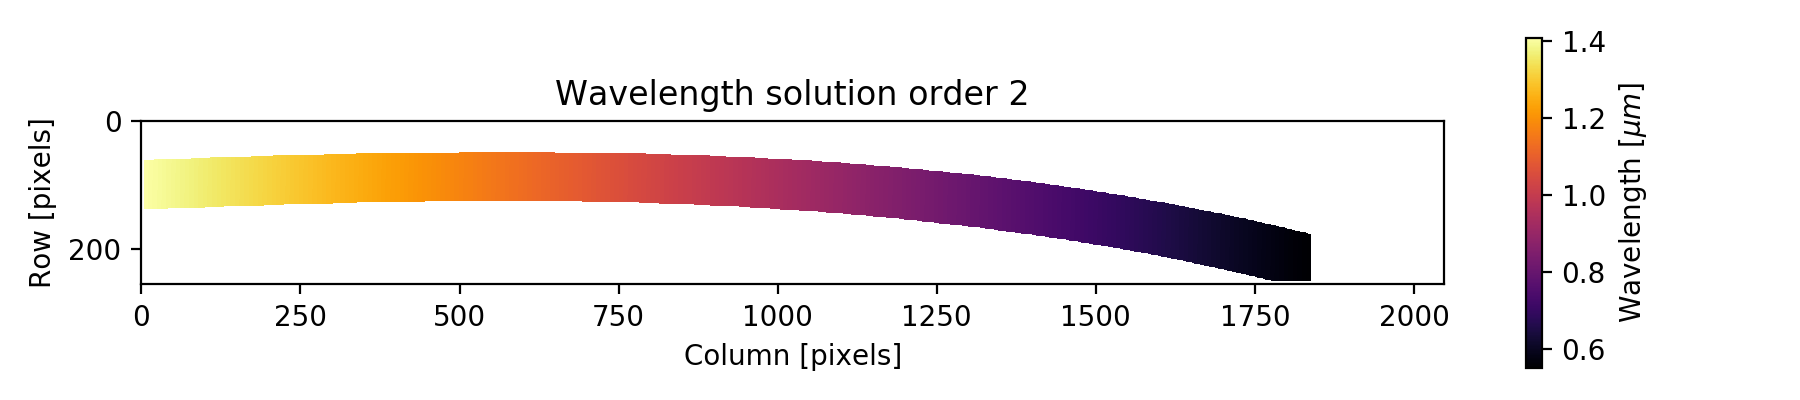

<IPython.core.display.Javascript object>


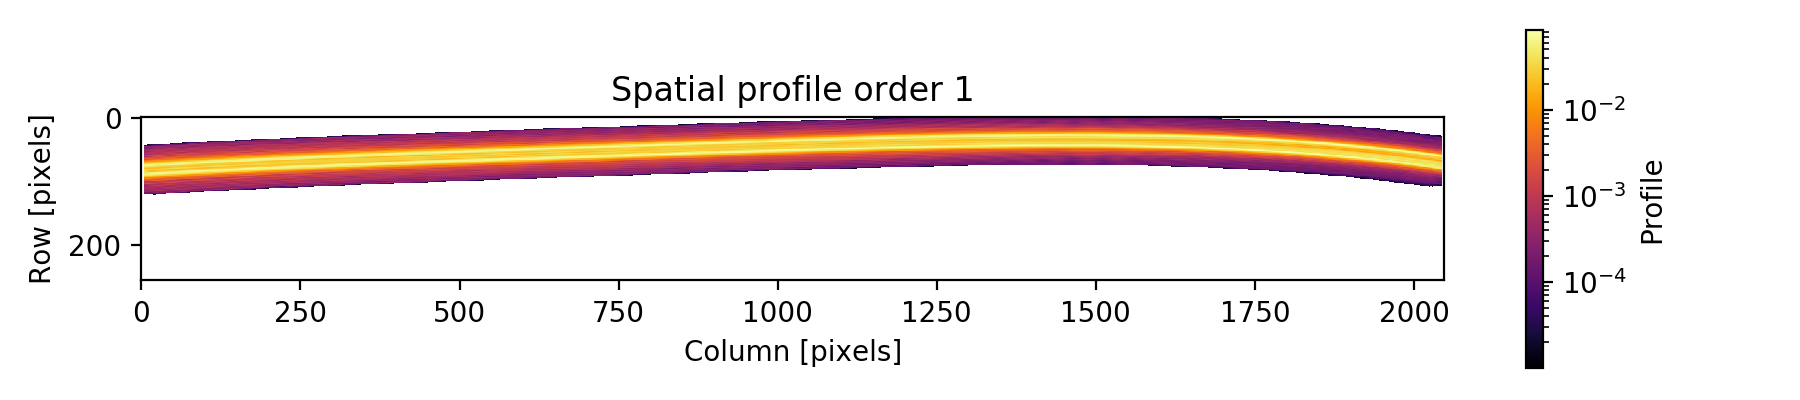

<IPython.core.display.Javascript object>


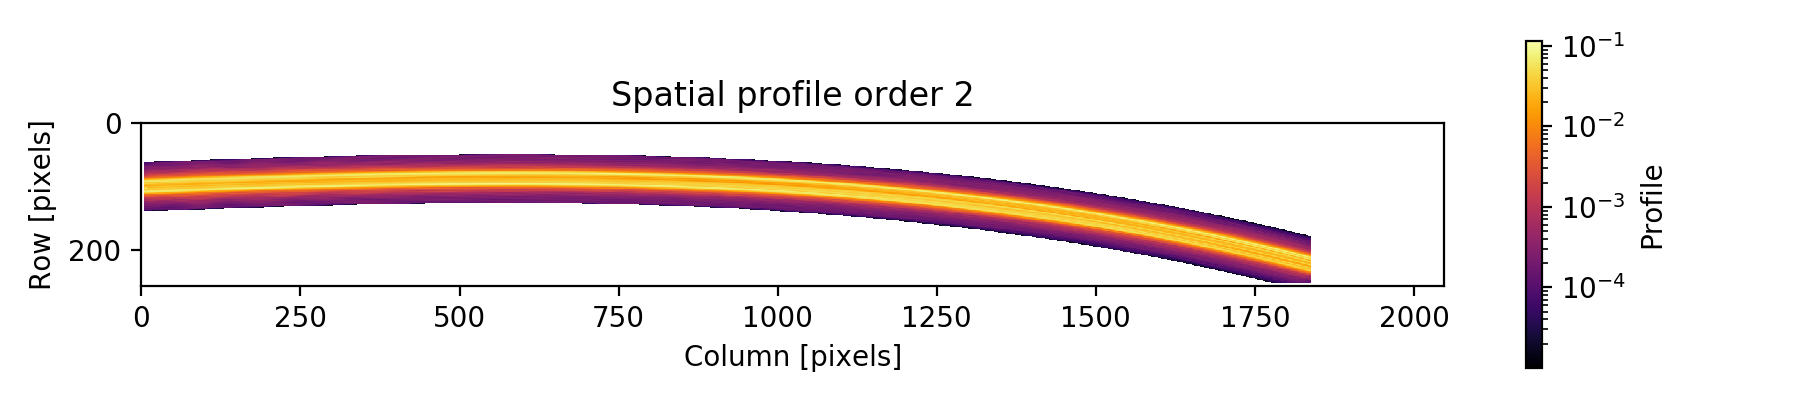

In [6]:
plt.figure(figsize=(9,2))
plt.title("Wavelength solution order 1")
plt.imshow(np.ma.array(wv_1, mask=P1<0.00001))
cmap = plt.colorbar(label="Wavelength [$\mu m$]")
plt.ylabel('Row [pixels]')
plt.xlabel('Column [pixels]')
plt.tight_layout()

plt.figure(figsize=(9,2))
plt.title("Wavelength solution order 2")
plt.imshow(np.ma.array(wv_2, mask=(P2<0.00001)|(wv_2==0)))
cmap = plt.colorbar(label="Wavelength [$\mu m$]")
plt.ylabel('Row [pixels]')
plt.xlabel('Column [pixels]')
plt.tight_layout()

plt.figure(figsize=(9,2))
plt.title("Spatial profile order 1")
plt.imshow(np.ma.array(P1, mask=P1<0.00001), norm=LogNorm())
cmap = plt.colorbar(label="Profile")
plt.ylabel('Row [pixels]')
plt.xlabel('Column [pixels]')
plt.tight_layout()

plt.figure(figsize=(9,2))
plt.title("Spatial profile order 2")
plt.imshow(np.ma.array(P2, mask=(P2<0.00001)|(wv_2==0)), norm=LogNorm())
cmap = plt.colorbar(label="Profile")
plt.ylabel('Row [pixels]')
plt.xlabel('Column [pixels]')
plt.tight_layout()

# Setup for simulation

## Wavelength grid

In [7]:
lam_simu = get_soss_grid([P1, P2], [wv_1, wv_2], n_os=15)

The finer sampling is used for overlaping wavelenghts

<IPython.core.display.Javascript object>


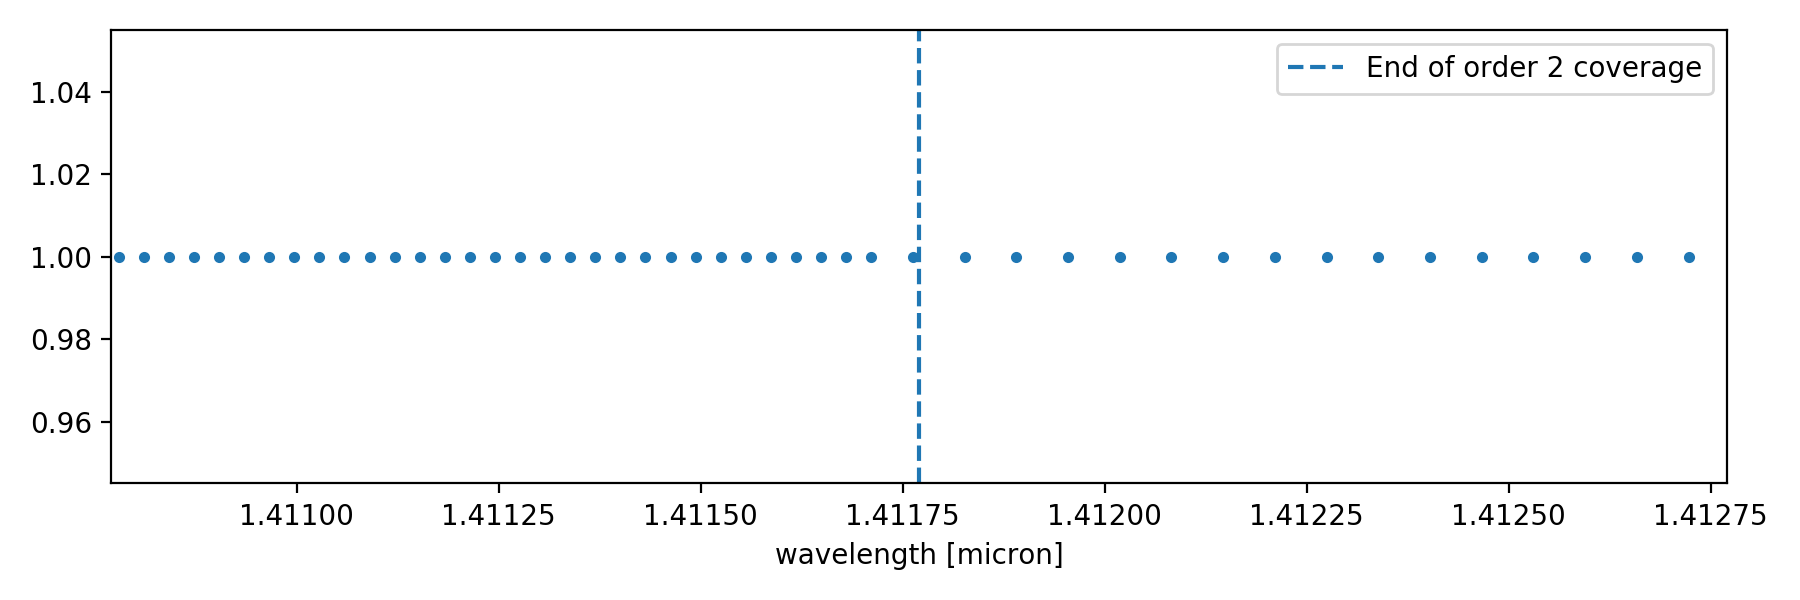

In [8]:
plt.plot(lam_simu, np.ones(lam_simu.shape), ".")
plt.axvline(np.max(wv_2), linestyle="--", label="End of order 2 coverage")
plt.xlabel('wavelength [micron]')
plt.xlim(np.max(wv_2) - 0.001, np.max(wv_2) + 0.001)
plt.legend()
plt.tight_layout()

## Initiate 2 simulations.
(One without order 2, so no contamination, and with order 2)

In [9]:
# Choose a small threshold for the spatial profile cut
# (less than for a normal extraction)
simu = TrpzOverlap([P1,P2], [wv_1,wv_2], lam_grid=lam_simu, thresh=1e-8, c_kwargs={'thresh':1e-5})

# ***** WARNING *******
# Since it's oversampled, may take some time to initiate
# (mostly because of the convolution matrix)

### Some references files are directly included in in TrpzOverlap.
Here are some examples (no need to import it)

In [10]:
from throughput import ThroughputSOSS

<IPython.core.display.Javascript object>


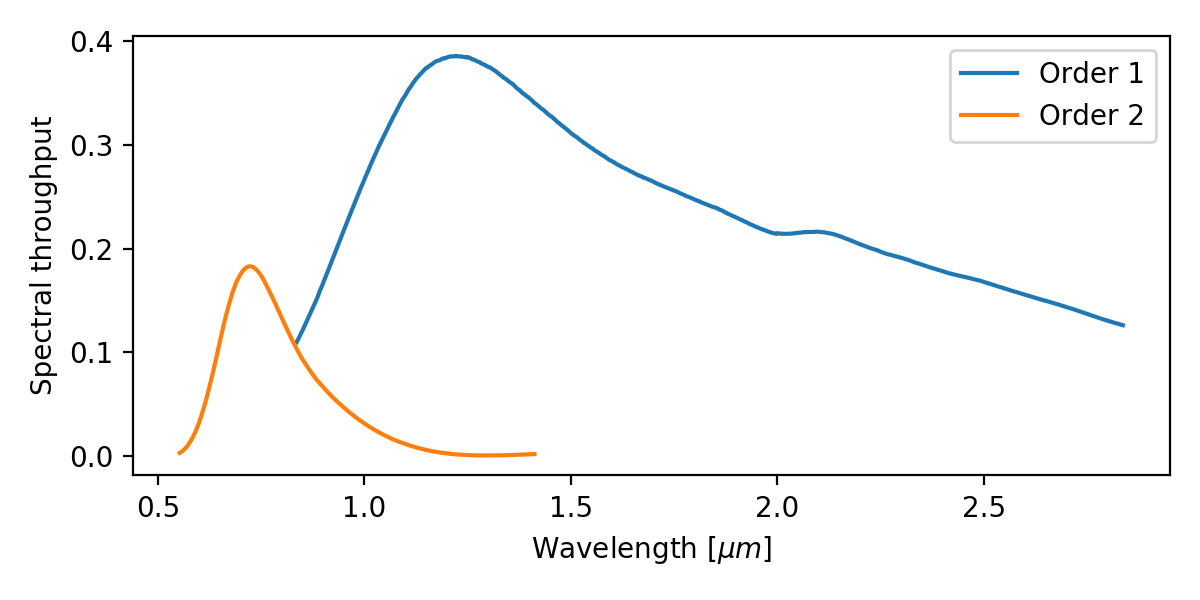

In [11]:
plt.figure(figsize=(6,3))
plt.plot(simu.lam_grid_c(0), ThroughputSOSS(1)(simu.lam_grid_c(0)), label="Order 1")
plt.plot(simu.lam_grid_c(1), ThroughputSOSS(2)(simu.lam_grid_c(1)), label="Order 2")
plt.legend()
plt.ylabel("Spectral throughput")
plt.xlabel("Wavelength [$\mu m$]")
plt.tight_layout()

In [12]:
from convolution import WebbKer

<IPython.core.display.Javascript object>


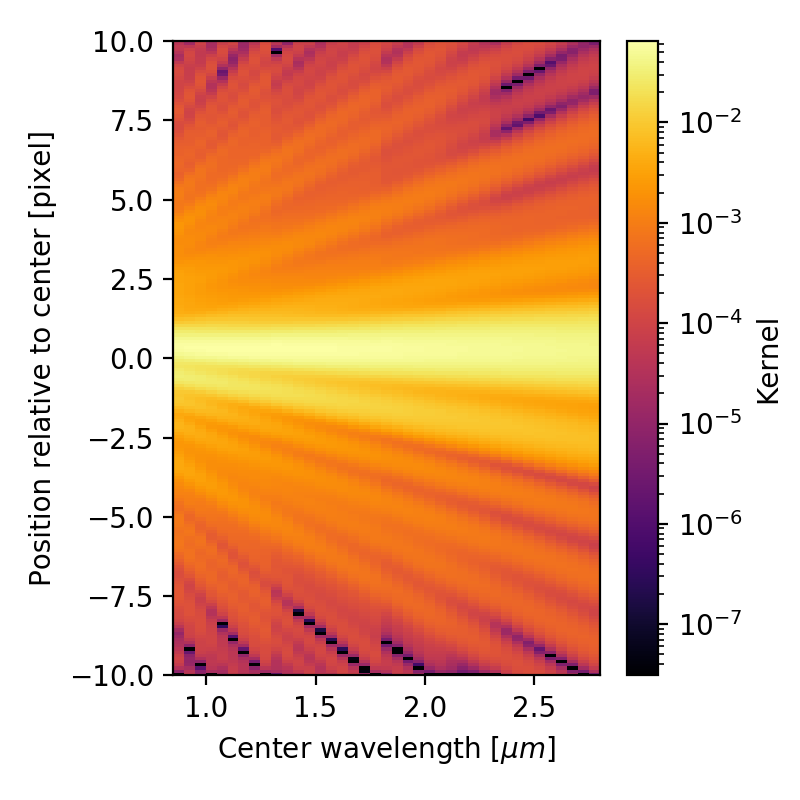

<IPython.core.display.Javascript object>


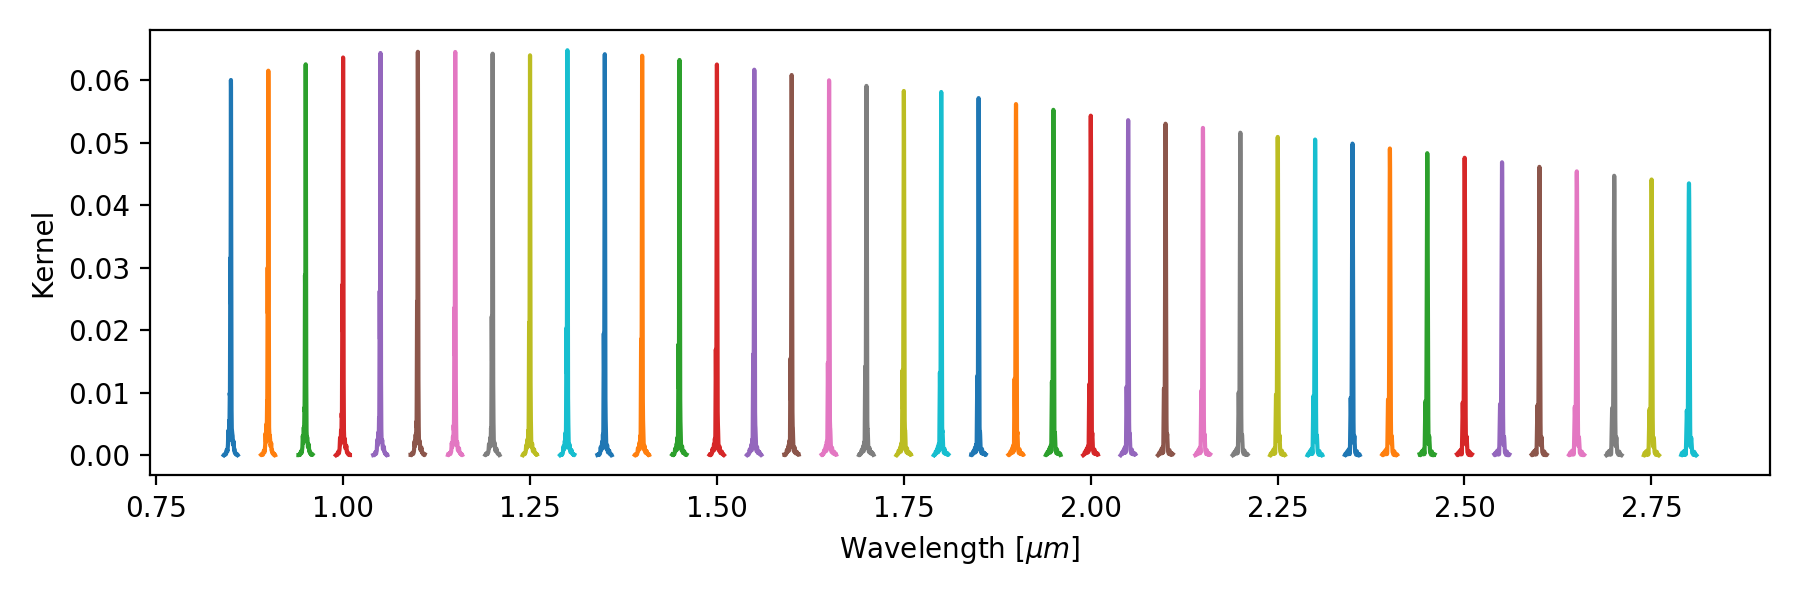

(<Figure size 400x400 with 2 Axes>, <Figure size 900x300 with 1 Axes>)

In [13]:
WebbKer(wv_1).show()

# Case 1: Sinus function

## Inject sinus

In [14]:
# Generate flux to inject
flux = 1 + 0.5 * np.sin(lam_simu*500)
# Multiplication by a fudge factor to get
# a realistic number of counts on the detector
flux *= 1e12
# flux *= 1e9

# Inject (`rebuild` could also take a callable` input.)
scidata = simu.rebuild(flux)

Note that you can rebuild each orders separately.
Just give the index (from the `lam_list` or `p_list`) of the order you want to inject.

In [15]:
# `orders=[0]` will simulate order 1
clean_data = simu.rebuild(flux, orders=[0])

<IPython.core.display.Javascript object>


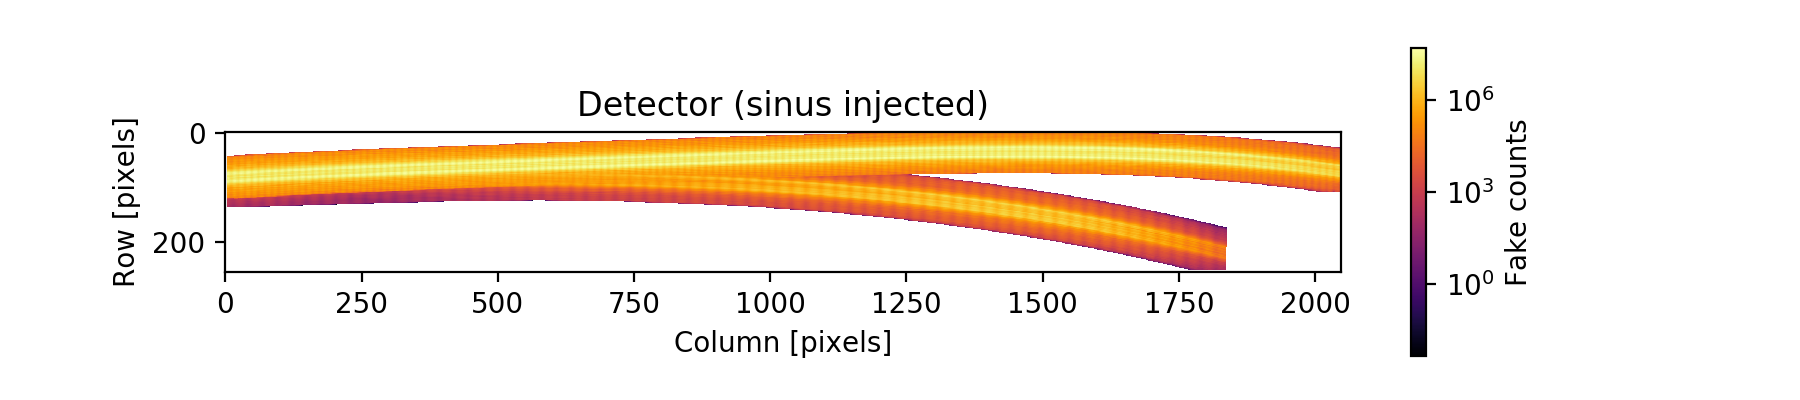

<IPython.core.display.Javascript object>


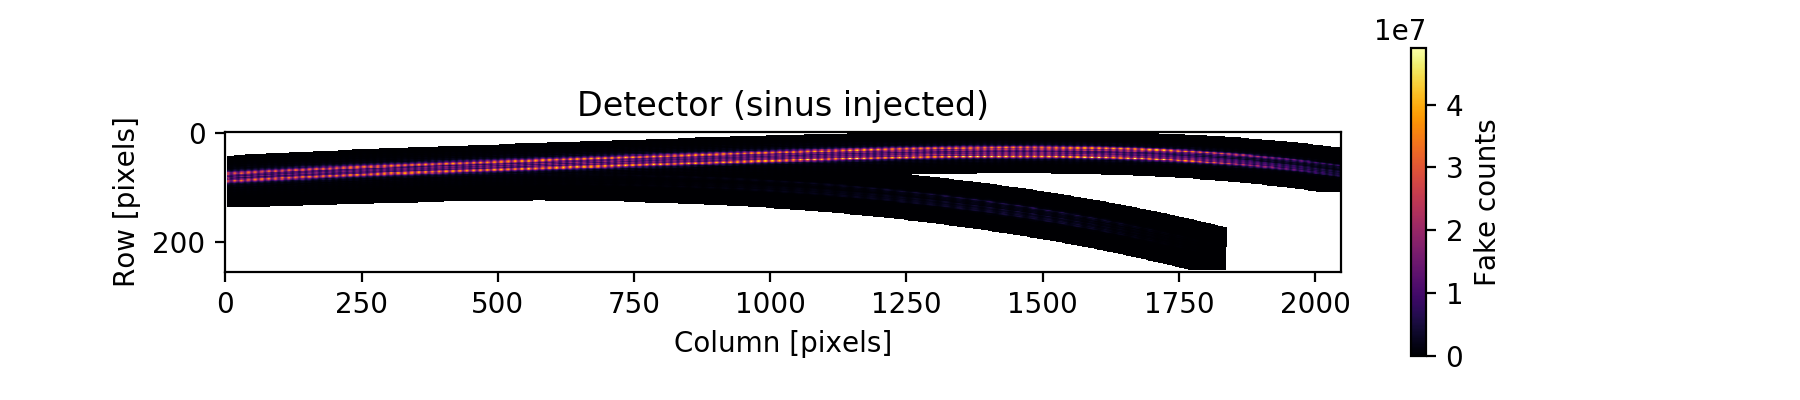

In [16]:
plt.figure(figsize=(9,2))
plt.imshow(scidata, norm=LogNorm())
cmap = plt.colorbar()
plt.title('Detector (sinus injected)')
plt.ylabel('Row [pixels]')
plt.xlabel('Column [pixels]')
cmap.set_label('Fake counts')

plt.figure(figsize=(9,2))
plt.imshow(scidata)
cmap = plt.colorbar()
plt.title('Detector (sinus injected)')
plt.ylabel('Row [pixels]')
plt.xlabel('Column [pixels]')
cmap.set_label('Fake counts')

## Init extraction

In [17]:
wv_range = [0.6, 2.836]
n_oversample = 1

# Define grid for extraction based only on order 1 sampling
# Just for demonstration (better to use `get_soss_grid`)
lam_grid = grid_from_map(wv_1, P1, wv_range=wv_range)
lam_grid = oversample_grid(lam_grid, n_os=n_oversample)
lam_grid = np.unique(lam_grid)

In [18]:
# Init extraction object
# Use more restrictive cut on the spatial and the kernel
extra = TrpzOverlap([P1,P2], [wv_1,wv_2], scidata=scidata, lam_grid=lam_grid, thresh=1e-5,
                    c_kwargs={'thresh':0.001})

## Extract

In [19]:
f_k = extra.extract()

Note that f_k is not exactly what we are looking for. It is finer than the resolution of the spectrometer,  <br />
so it gives unstable results as shown in the following plot. <br/>
I am in the process oof implementing a regularization to improve the stability and insure continuus solutions of the system.

### Raw f_k

<IPython.core.display.Javascript object>


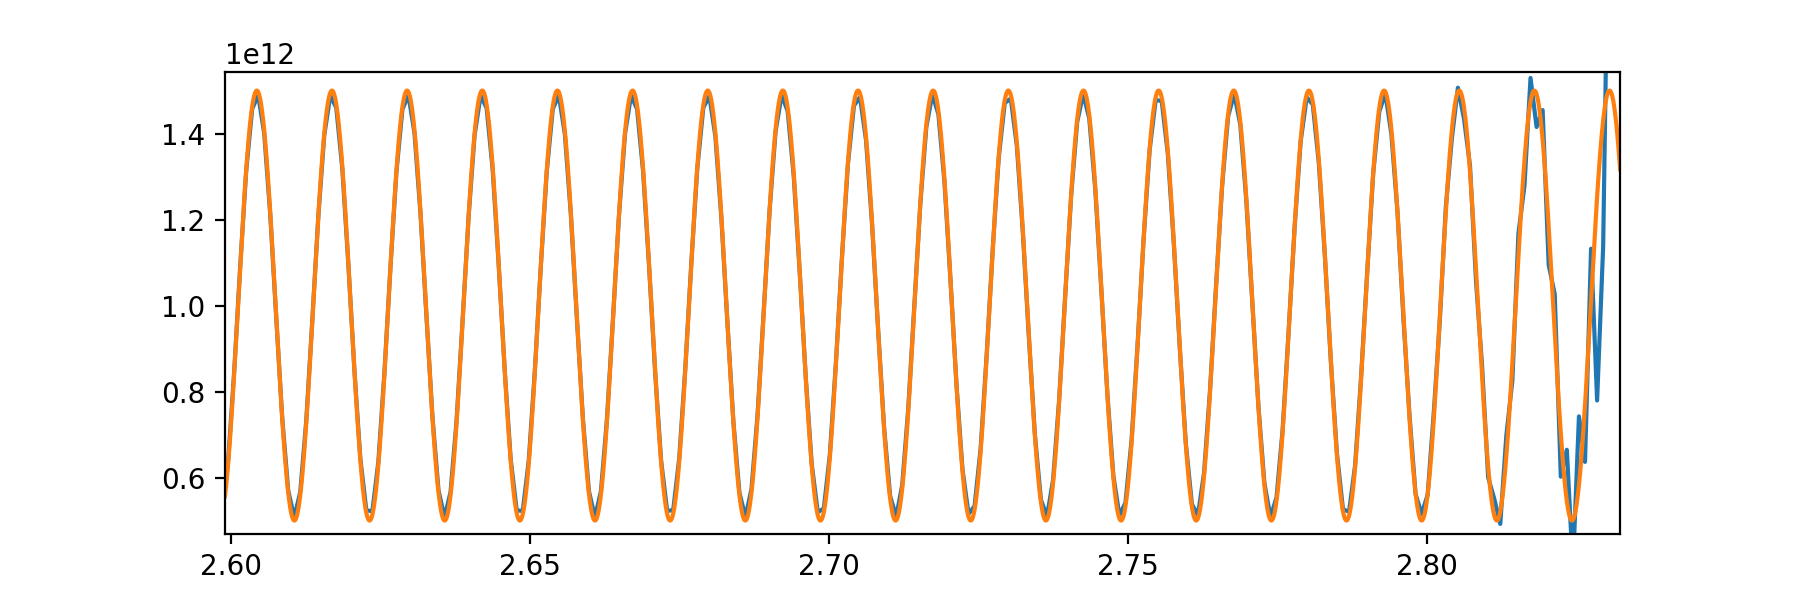

(2.5, 2.84)

In [20]:
plt.plot(extra.lam_grid, f_k)
plt.plot(simu.lam_grid, flux)
plt.xlim(2.5,2.84)

### f_k convolved and binned
To get better results, one option is to convolve f_k and bin.

In [21]:
f_k_c = extra.c_list[0].dot(f_k)
f_k_bin = convolve(f_k_c, Box1DKernel(2*n_oversample),
                   preserve_nan=True, boundary='extend')
# Note that the binned flux for the simulation
# is only valid for the part covered only by order 1
f_th_bin = convolve(simu.c_list[0].dot(flux), Box1DKernel(10*2),
                    preserve_nan=True, boundary='extend')
f_th_bin = interp1d(simu.lam_grid_c(0), f_th_bin, kind='cubic')

<IPython.core.display.Javascript object>


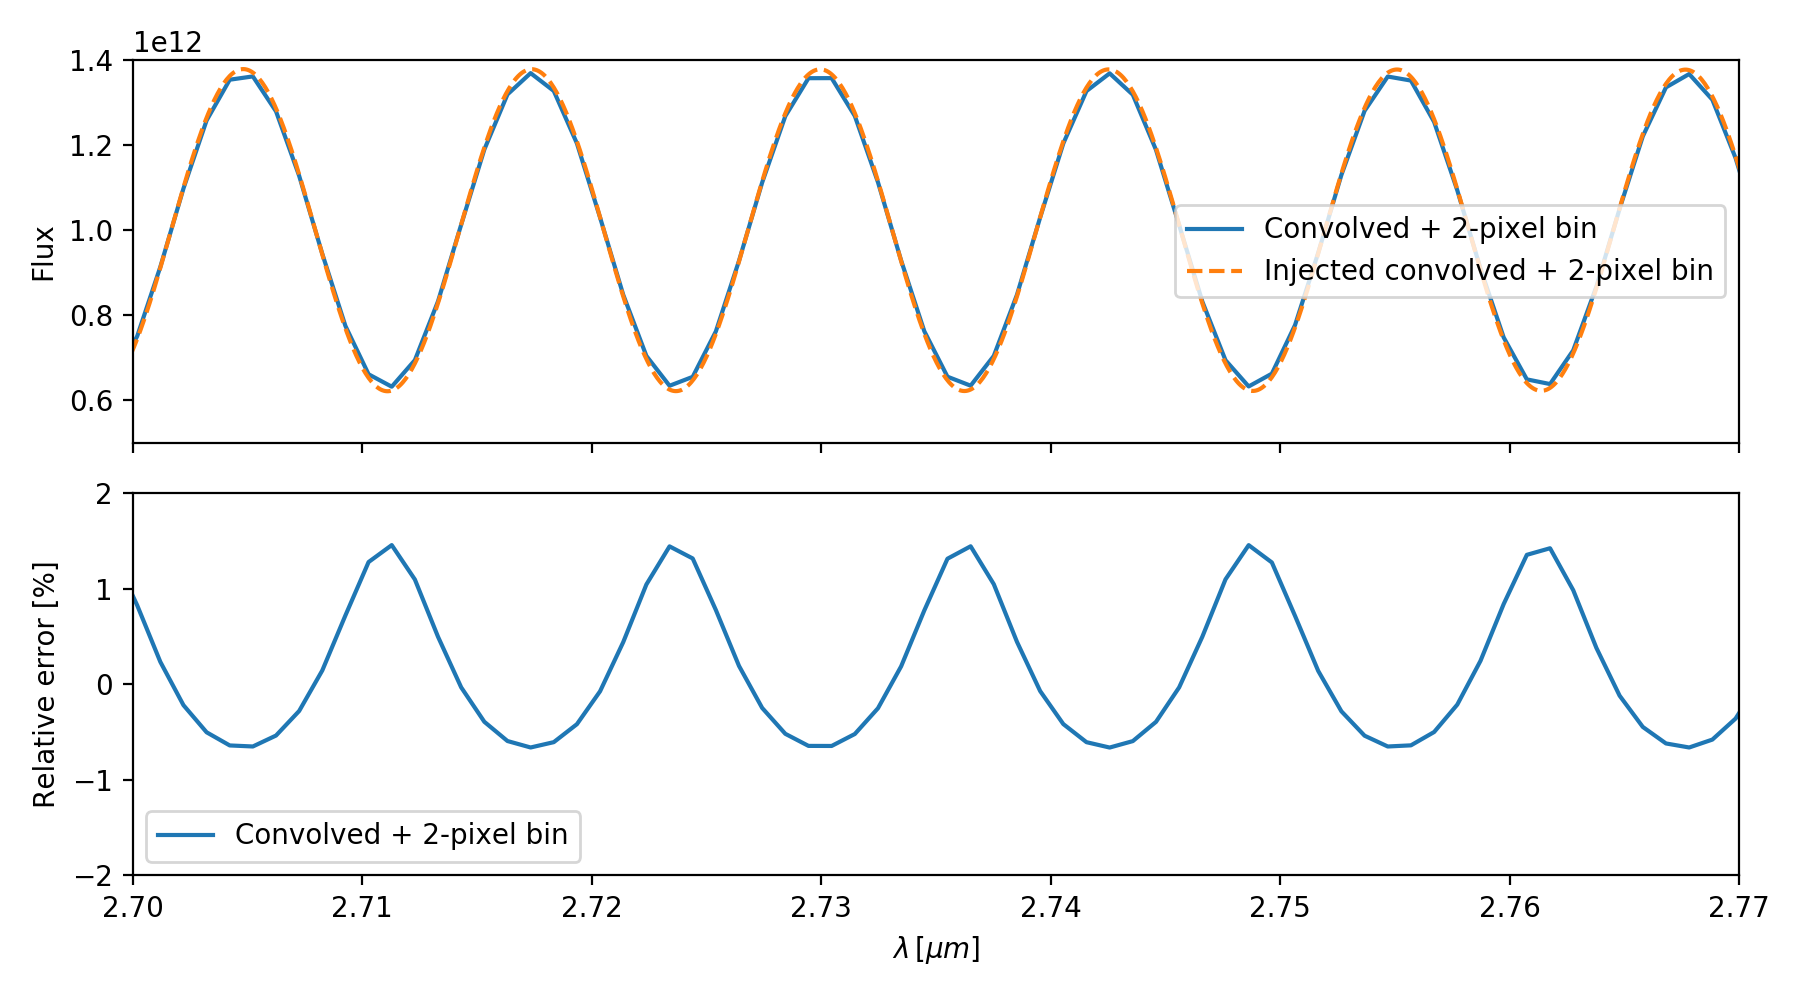

In [22]:
fig, ax = plt.subplots(2,1,sharex=True, figsize=(9,5))

ax[0].plot(extra.lam_grid_c(0), f_k_bin, label='Convolved + 2-pixel bin')
ax[0].plot(simu.lam_grid_c(0), f_th_bin(simu.lam_grid_c(0)), '--', label='Injected convolved + 2-pixel bin')
ax[0].legend()

err_c = (f_k_c - f_th_bin(extra.lam_grid_c(0)))/f_th_bin(extra.lam_grid_c(0))
err_bin = (f_k_bin - f_th_bin(extra.lam_grid_c(0)))/f_th_bin(extra.lam_grid_c(0))
ax[-1].plot(extra.lam_grid_c(0), 100*err_bin, label='Convolved + 2-pixel bin')
ax[-1].legend()


ax[0].set_ylim(0.5e12, 1.4e12)
ax[-1].set_ylim(-2e0,2e0)

ax[0].set_ylabel('Flux')
ax[1].set_ylabel('Relative error [%]')
ax[-1].set_ylabel('Relative error [%]')
plt.xlim(2.7000,2.7700)
plt.xlabel('$\lambda \, [\mu m]$')
plt.tight_layout()

### Rebuilt (projection on the detector)
But the best is to recreate the 2-D image of the detector (after all, the algorithm is made to optimize that)

In [23]:
rebuilt = extra.rebuild(f_k)

<IPython.core.display.Javascript object>


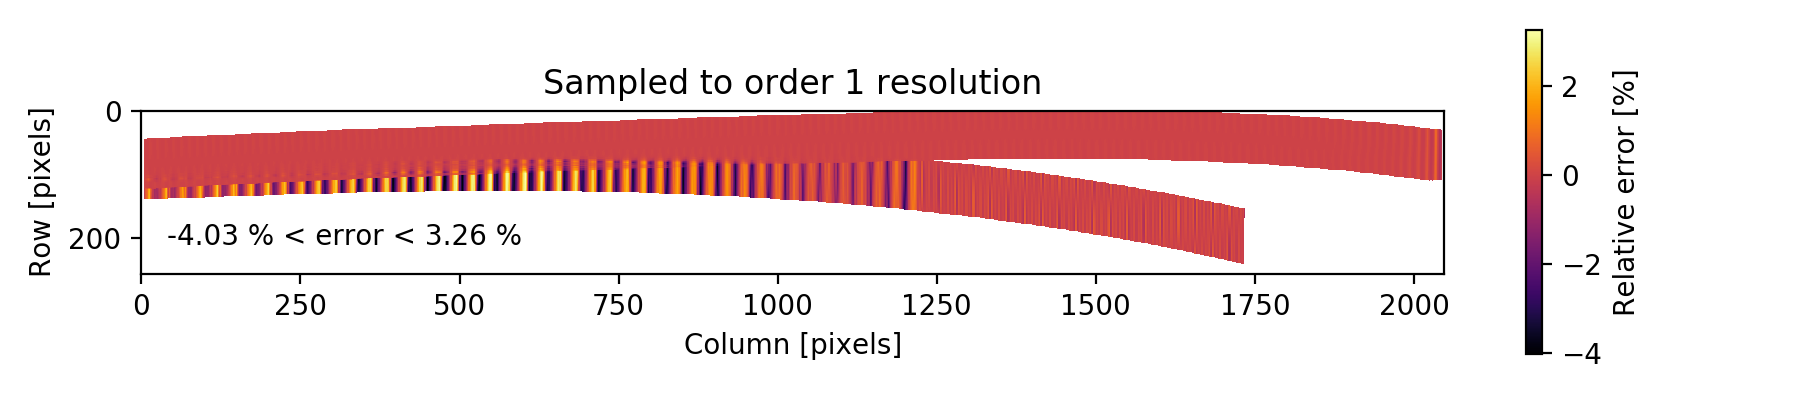

<IPython.core.display.Javascript object>


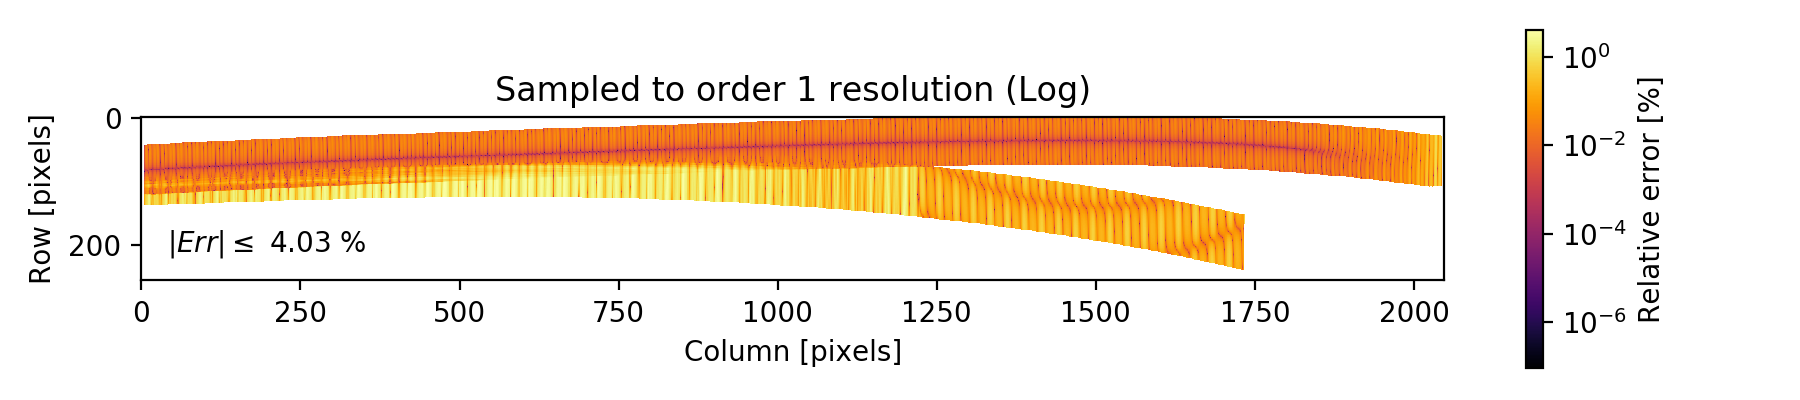

<IPython.core.display.Javascript object>


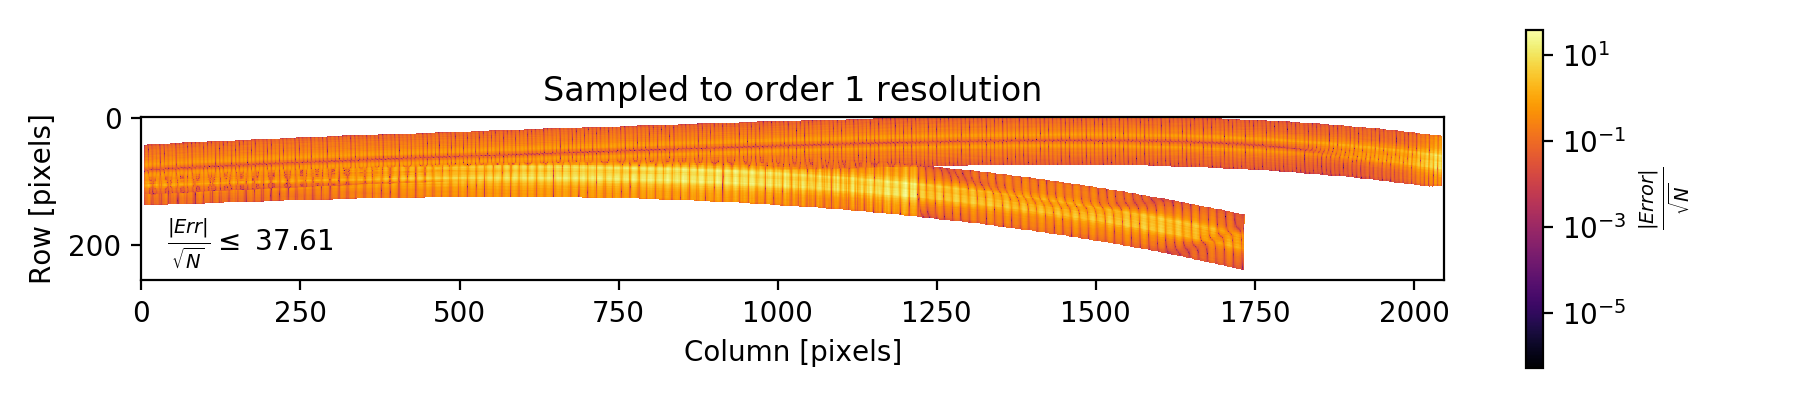

In [24]:
plt.figure(figsize=(9,2))
plt.title("Sampled to order 1 resolution")
plt.imshow((rebuilt-scidata)/scidata * 100)
cmap = plt.colorbar(label="Relative error [%]")
plt.text(40,210, "{:.2f} % < error < {:.2f} %".format(cmap.vmin, cmap.vmax))
plt.ylabel('Row [pixels]')
plt.xlabel('Column [pixels]')
plt.tight_layout()

plt.figure(figsize=(9,2))
plt.title("Sampled to order 1 resolution (Log)")
plt.imshow(np.abs(rebuilt-scidata)/scidata * 100, norm=LogNorm())
cmap = plt.colorbar(label="Relative error [%]")
plt.text(40,210, r"$| Err | \leq$" + " {:.2f} %".format(cmap.vmax))
plt.ylabel('Row [pixels]')
plt.xlabel('Column [pixels]')
plt.tight_layout()

plt.figure(figsize=(9,2))
plt.title("Sampled to order 1 resolution")
plt.imshow(np.abs(rebuilt-scidata)/np.sqrt(scidata),norm=LogNorm())
cmap = plt.colorbar(label=r"$\frac{| Error |}{\sqrt{N}}$")
plt.text(40,210, r"$\frac{|Err|}{\sqrt{N}} \leq$" + " {:.2f}".format(cmap.vmax))
plt.ylabel('Row [pixels]')
plt.xlabel('Column [pixels]')
plt.tight_layout()

The major source of error is due to the coarse sampling compared to order 2 resolution and the convolution kernels. <br/> 
This causes the error seen in the order 2 where the wavelength start to be shared with order 1

### Non-uniform grid
Use a finer grid for the wavelengths covered by order 2

In [25]:
n_oversample = 2

lam_grid = get_soss_grid([P1, P2], [wv_1, wv_2], n_os=n_oversample)

In [26]:
extra = TrpzOverlap([P1,P2], [wv_1,wv_2], scidata=scidata, lam_grid=lam_grid, thresh=1e-5,
                    c_kwargs={'thresh':0.0001})

In [27]:
f_k = extra.extract()
rebuilt = extra.rebuild(f_k)

<IPython.core.display.Javascript object>


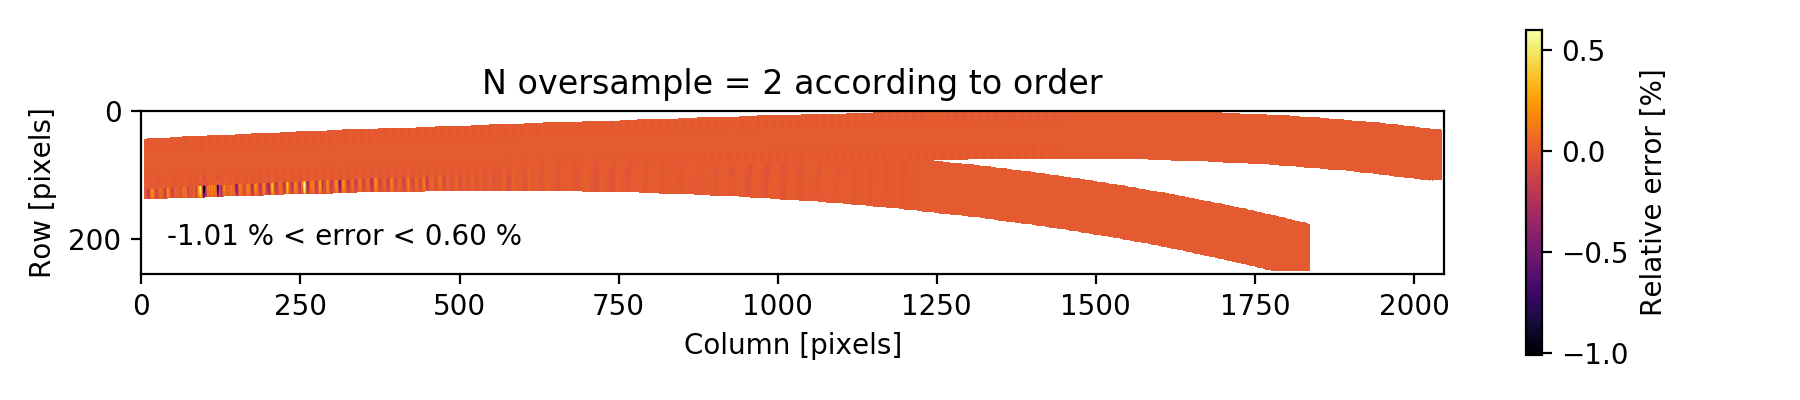

<IPython.core.display.Javascript object>


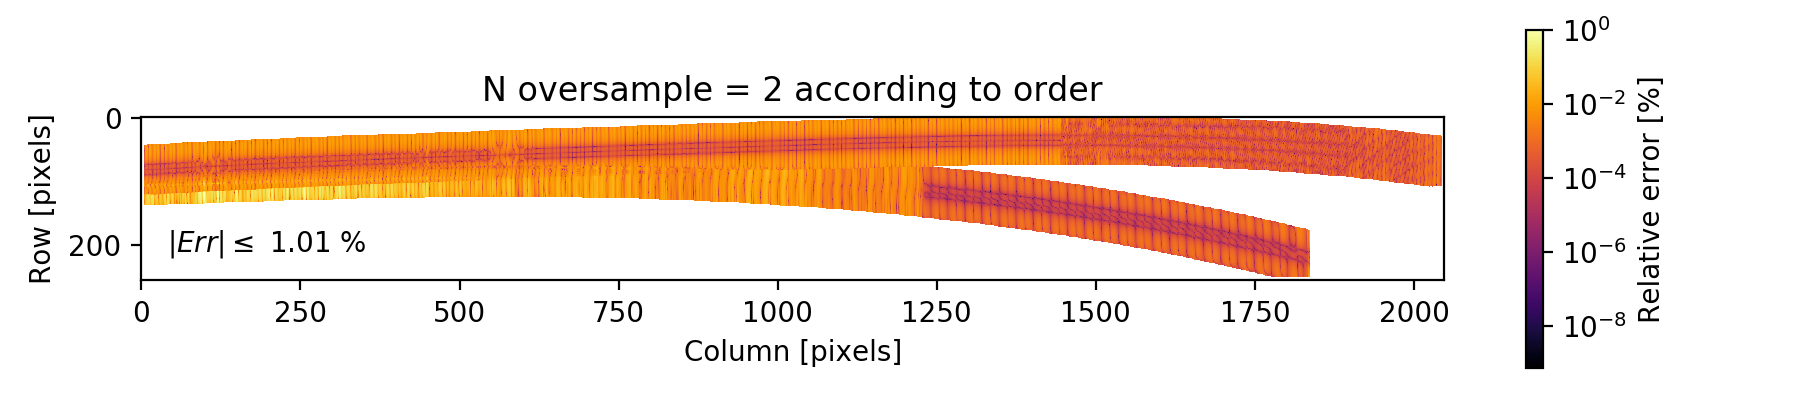

<IPython.core.display.Javascript object>


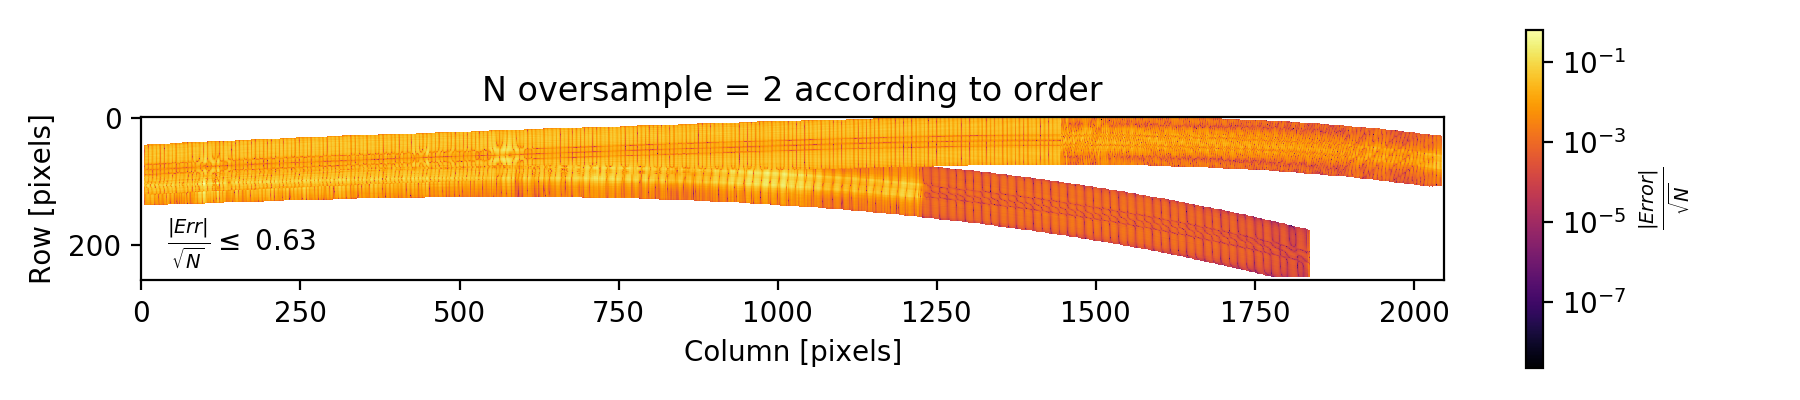

In [28]:
plt.figure(figsize=(9,2))
plt.title("N oversample = {} according to order".format(n_oversample))
plt.imshow((rebuilt-scidata)/scidata * 100)
cmap = plt.colorbar(label="Relative error [%]")
plt.text(40,210, "{:.2f} % < error < {:.2f} %".format(cmap.vmin, cmap.vmax))
plt.ylabel('Row [pixels]')
plt.xlabel('Column [pixels]')
plt.tight_layout()

plt.figure(figsize=(9,2))
plt.title("N oversample = {} according to order".format(n_oversample))
plt.imshow(np.abs(rebuilt-scidata)/scidata * 100, norm=LogNorm())
cmap = plt.colorbar(label="Relative error [%]")
plt.text(40,210, r"$| Err | \leq$" + " {:.2f} %".format(cmap.vmax))
plt.ylabel('Row [pixels]')
plt.xlabel('Column [pixels]')
plt.tight_layout()

plt.figure(figsize=(9,2))
plt.title("N oversample = {} according to order".format(n_oversample))
plt.imshow(np.abs(rebuilt-scidata)/np.sqrt(scidata),norm=LogNorm())
cmap = plt.colorbar(label=r"$\frac{| Error |}{\sqrt{N}}$")
plt.text(40,210, r"$\frac{|Err|}{\sqrt{N}} \leq$" + " {:.2f}".format(cmap.vmax))
plt.ylabel('Row [pixels]')
plt.xlabel('Column [pixels]')
plt.tight_layout()

# Case 2: Sinus function + noise

## Add noise

In [29]:
data_noise = scidata.copy()
clean_data_noise = clean_data.copy()

In [30]:
# Add Poisson noise
data_noise[np.isnan(data_noise)] = 0
data_noise = np.random.poisson(data_noise)
clean_data_noise[np.isnan(clean_data_noise)] = 0
clean_data_noise = np.random.poisson(clean_data_noise)

# Add background noise
data_noise = data_noise + np.random.normal(scale=20, size=data_noise.shape)
clean_data_noise = clean_data_noise + np.random.normal(scale=20, size=clean_data_noise.shape)

# Get the noise
noise = data_noise-scidata
noise_clean = clean_data_noise-clean_data

## Init extraction

In [31]:
sig = np.sqrt(scidata + 20.**2)  # Map of expected noise
n_oversample = 2

lam_grid = get_soss_grid([P1, P2], [wv_1, wv_2], n_os=n_oversample)

In [32]:
# Init extraction object
# Use more restrictive cut on the spatial and the kernel
extra = TrpzOverlap([P1,P2], [wv_1,wv_2], scidata=data_noise, lam_grid=lam_grid, thresh=1e-5,
                     c_kwargs={'thresh':0.0001}, sig=sig)

In [33]:
f_k = extra.extract()

In [34]:
rebuilt = extra.rebuild(f_k)

<IPython.core.display.Javascript object>


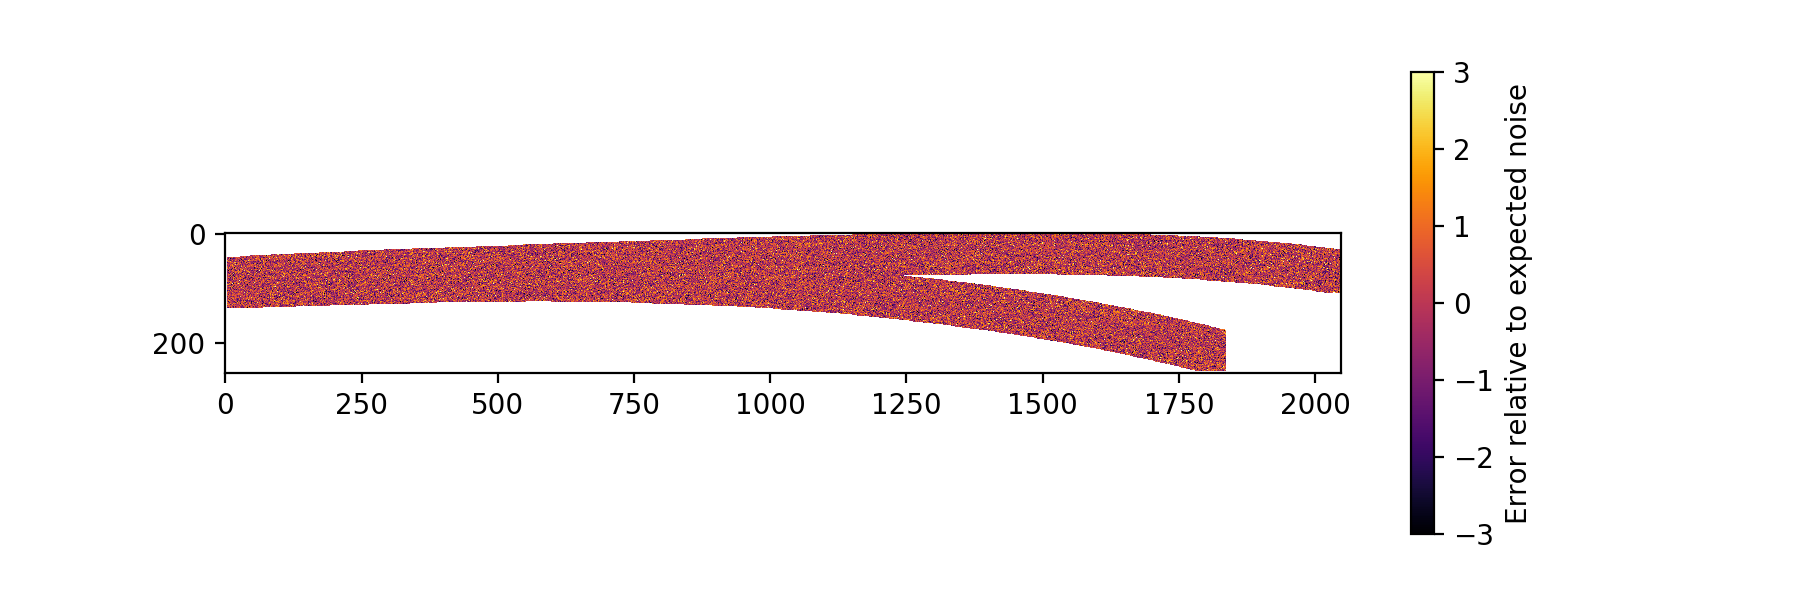

In [35]:
plt.imshow((rebuilt-data_noise)/sig, vmin=-3, vmax=3)
plt.colorbar(label="Error relative to expected noise")

# Tips that may be useful for iteration on spatial profile

## Extract a first estimate of the order 1 spectrum
This first step could be done with a classic method. <br/>
Let say `P1` and `P2` are estimates of the spatial profile

In [36]:
# Grid from order 1
lam_grid = grid_from_map(wv_1, P1)
lam_grid = oversample_grid(lam_grid, n_os=1)  # No effect if n_os=1

# Init with only order 1 and mask the order 2 pixels
mask = (P2 >= 1.0e-4)
extra = TrpzOverlap([P1], [wv_1], scidata=data_noise, mask=mask,
                    lam_grid=lam_grid, thresh=1e-5, 
                    c_kwargs={'thresh':0.0001}, sig=sig, orders=[1])

In [37]:
f_k = extra.extract()
# The convolve flux is obtained by a multipication
# with the convulution matrix
f_k_c = extra.c_list[0].dot(f_k)

<IPython.core.display.Javascript object>


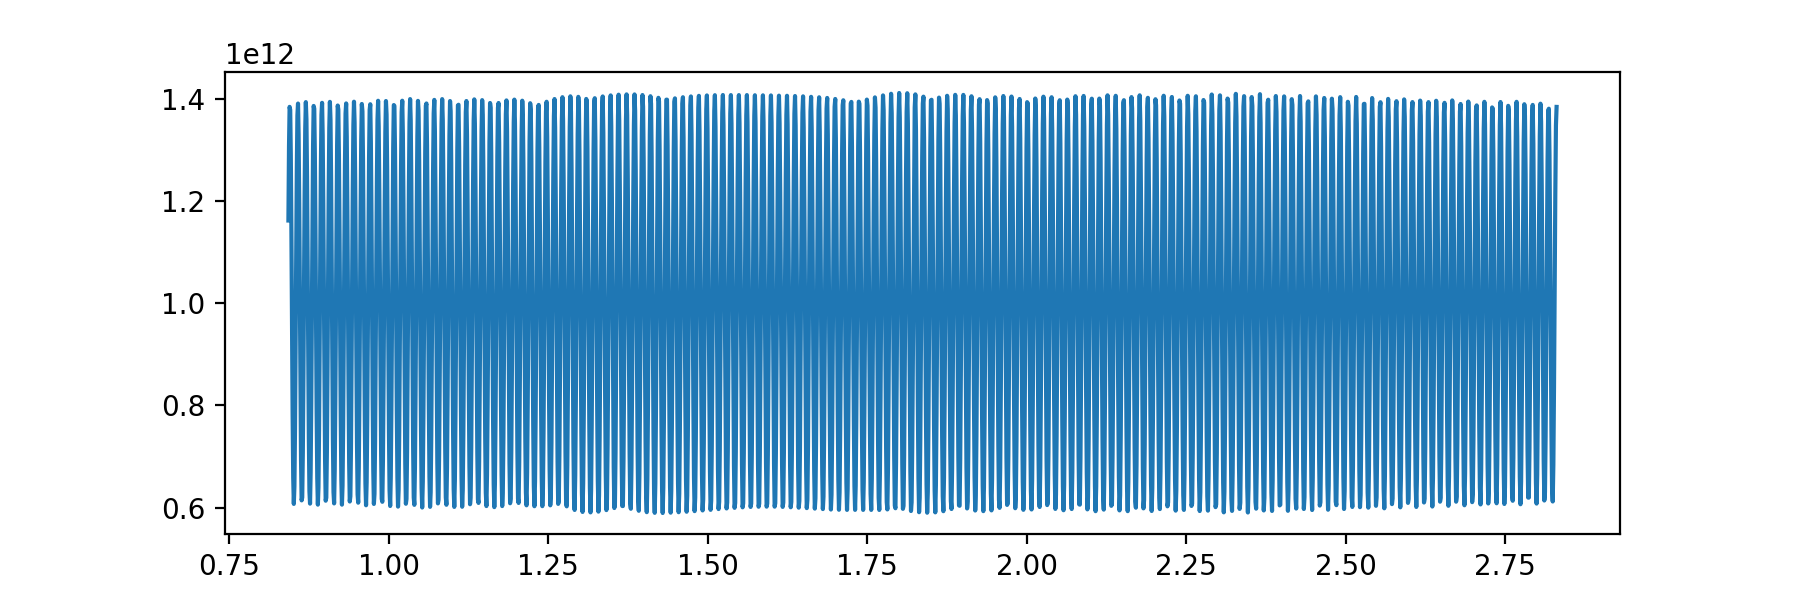

In [38]:
plt.plot(extra.lam_grid_c(0), f_k_c)

<IPython.core.display.Javascript object>


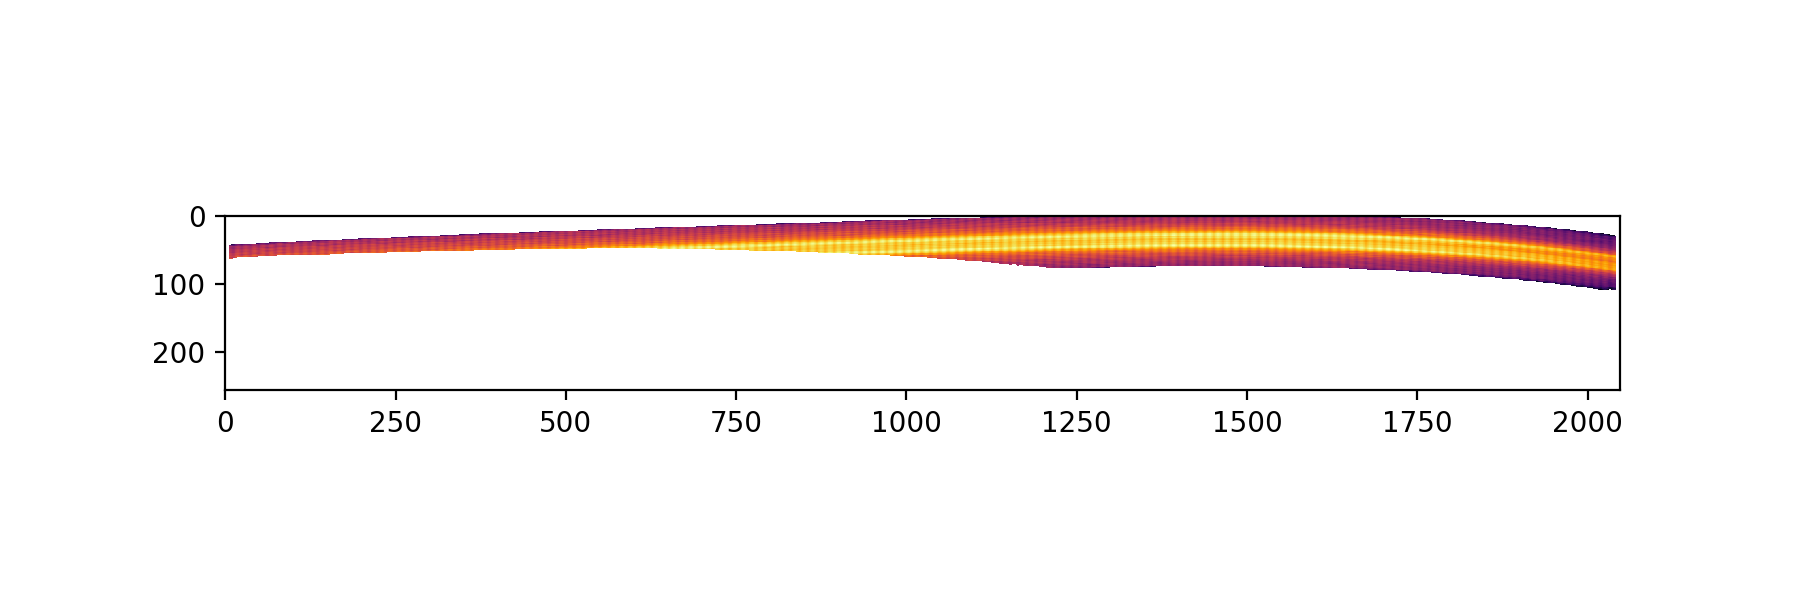

In [39]:
plt.imshow(extra.rebuild(f_k), norm=LogNorm())

## Iterate on spatial profile, throughput, data or error map
It is possible to iterate on these reference files without re-initiating an object

In [52]:
# Init full extraction
lam_grid = get_soss_grid([P1, P2], [wv_1, wv_2], n_os=2)

# Init a full extraction
extra = TrpzOverlap([P1, P2], [wv_1, wv_2], scidata=data_noise,
                    lam_grid=lam_grid, thresh=1e-5, 
                    c_kwargs={'thresh':0.0001}, sig=sig)

Iterate to get a best estimate of spatial profile.

In [53]:
# First estimate of f_k
f_k = extra.extract()
p_list_new = np.array([P1, P2])
scale_factor = 0.1
for i in range(10):
    # Define a correction map
    rebuilt = extra.rebuild(f_k)
    rel_err = (data_noise - rebuilt) / rebuilt
    # Weigh the correction depending on the order contribution at each pixel
    weigh_list = p_list_new
    # New spatial profiles
    correction = scale_factor * weigh_list * rel_err
    p_list_new = p_list_new + correction
    # Re-extract
    f_k = extra.extract(p_list=p_list_new)

Little instability problem... coould be solve with tikhonov regularisation?

<IPython.core.display.Javascript object>


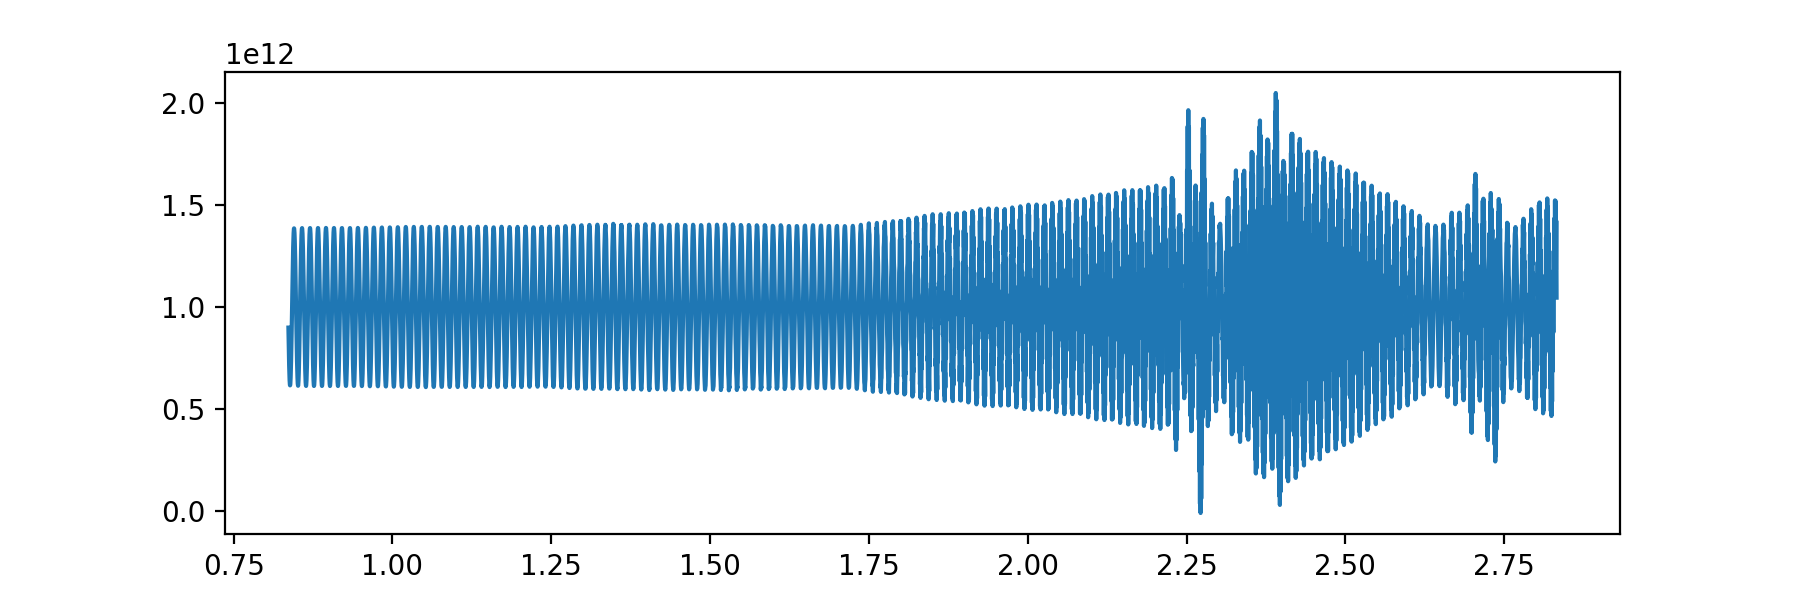

In [54]:
plt.plot(extra.lam_grid_c(0), extra.c_list[0].dot(f_k))

<IPython.core.display.Javascript object>


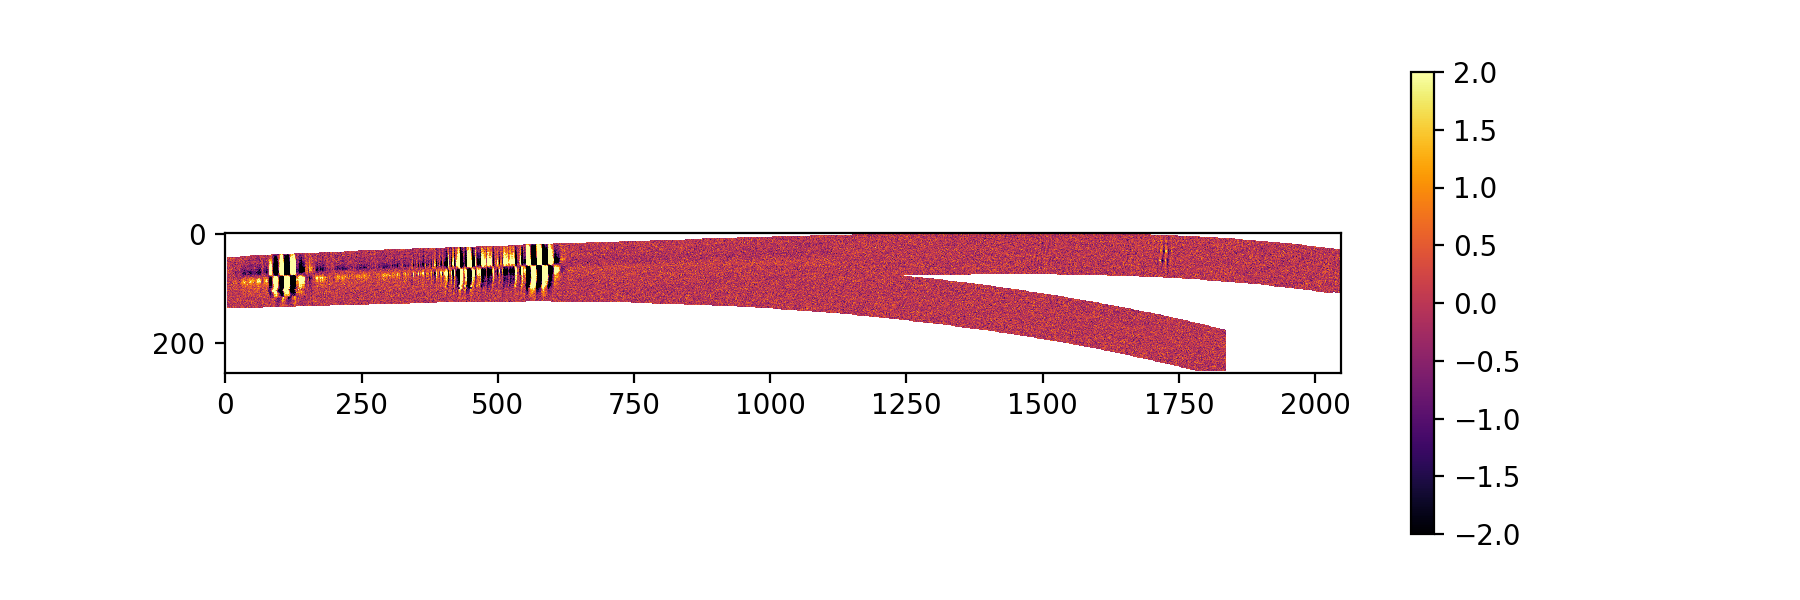

In [55]:
rebuilt = extra.rebuild(f_k)
err = (data_noise - rebuilt)
plt.imshow(err/sig, vmin=-2, vmax=2)
plt.colorbar()